<a href="https://colab.research.google.com/github/antcc/proyecto-vc/blob/master/yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de caras con YOLOv3 en widerface
Usamos la base de datos [WIDERFACE](http://shuoyang1213.me/WIDERFACE/), que consta de 12881 imágenes de entrenamiento y 3220 imágenes de validación, todas anotadas con los valores de ground truth de las bounding boxes. Usaremos la validación como test para evaluar el modelo.
Se necesita tener la estructura de ficheros indicada en el apéndice de la memoria del proyecto.
Primero montamos el drive y definimos funciones auxiliares que usaremos más tarde en el código.

In [11]:
%tensorflow_version 1.x
import sys 
import os
import json
from google.colab import drive

# Directorio de trabajo
drive.mount("/content/drive", force_remount = True)
DIR = "/content/drive/My Drive/vc/" 
sys.path.append(os.path.abspath(DIR))
model_loaded = False

# Archivo de configuración
config_path = DIR + "config.json"
with open(config_path) as config_buffer:
    config = json.loads(config_buffer.read())

Mounted at /content/drive


In [12]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pickle
from keras.models import load_model
from yolo.train import create_training_instances, create_model, create_callbacks
from yolo.generator import BatchGenerator
from yolo.utils.utils import normalize, evaluate_pascal, predict_boxes, get_yolo_boxes
from yolo.utils.bbox import draw_boxes, BoundBox
from yolo.voc import parse_one_voc_annotation, parse_voc_annotation
from tqdm import tqdm


def wait():
  input("------------Pulse una tecla para continuar------------")

#Funcion para normalizar una imagen entre los valores 0 y 1
def norm(img):
    return cv.normalize(img, None, 0.0, 1.0, cv.NORM_MINMAX)
#Devuelve una imagen leída con OpenCV en escala de grises (0) o en color (1)
#según el valor del flag
def read_im(fil, color_flag = 1):
    im = cv.imread(fil, color_flag)
    if len(im.shape) == 3:
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

    return im.astype(np.double)

#Muestra una imagen normalizada
def print_im(im, title = "", show = True, tam = (10, 10)):
    show_title = len(title) > 0
    if show:
        fig = plt.figure(figsize = tam)
    im = norm(im)  # Normalizamos a [0,1]
    plt.imshow(im, interpolation = None, cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    if show:
        if show_title:
            plt.title(title)
        plt.show()

#Funcion para mostrar varias imagenes en una misma venta con sus títulos si procede
def print_multiple_im(vim, titles = "", ncols = 2, tam = (10, 10)):
    show_title = len(titles) > 0

    nrows = len(vim) // ncols + (0 if len(vim) % ncols == 0 else 1)
    plt.figure(figsize = tam)

    for i in range(len(vim)):
        plt.subplot(nrows, ncols, i + 1)
        if show_title:
            plt.title(titles[i])
        print_im(vim[i], title = "", show = False)

    plt.show()

## Entrenamiento
Creamos un modelo de la red YOLOv3, que entrenamos con los datos de train del dataset.
Haciendo uso del archivo de configuración pasamos los parámetros necesarios a cada función que llamamos en la función de entrenamiento. Este archivo está explicado en la memoria y los nombres son descriptivos de lo que contienen.

In [13]:

def entrenamiento(epochs, fine_tune = 0, early_stop = False):
    #Leemos las anotaciones
    train_ints, _, labels, max_box_per_image = create_training_instances(
        config['train']['train_annot_folder'],
        config['train']['train_image_folder'],
        config['train']['cache_name'],
        config['valid']['valid_annot_folder'],
        config['valid']['valid_image_folder'],
        config['valid']['cache_name'],
        config['model']['labels']
    )
    print('\nTraining on: \t' + str(labels) + '\n')

    #train_ints = train_ints[:len(train_ints)//2]
    #labels = labels[:len(train_ints)//2]

    #Creamos ahora el generador de imágenes
    train_generator = BatchGenerator(
        instances           = train_ints,
        anchors             = config['model']['anchors'],
        labels              = labels,
        downsample          = 32, # ratio between input and output size
        max_box_per_image   = max_box_per_image,
        batch_size          = config['train']['batch_size'],
        min_net_size        = config['model']['min_input_size'],
        max_net_size        = config['model']['max_input_size'],
        shuffle             = True,
        jitter              = 0.3,
        norm                = normalize
    )

    #Creamos el modelo
    if os.path.exists(config['train']['saved_weights_name']):
        config['train']['warmup_epochs'] = 0
    warmup_batches = config['train']['warmup_epochs'] * (config['train']['train_times']*len(train_generator))

    os.environ['CUDA_VISIBLE_DEVICES'] = "0"

    train_model, infer_model = create_model(
        nb_class            = len(labels),
        anchors             = config['model']['anchors'],
        max_box_per_image   = max_box_per_image,
        max_grid            = [config['model']['max_input_size'], config['model']['max_input_size']],
        batch_size          = config['train']['batch_size'],
        warmup_batches      = warmup_batches,
        ignore_thresh       = config['train']['ignore_thresh'],
        saved_weights_name  = config['train']['saved_weights_name'],
        lr                  = config['train']['learning_rate'],
        grid_scales         = config['train']['grid_scales'],
        obj_scale           = config['train']['obj_scale'],
        noobj_scale         = config['train']['noobj_scale'],
        xywh_scale          = config['train']['xywh_scale'],
        class_scale         = config['train']['class_scale'],
        backend_path        = DIR + "models/backend.h5",
        fine_tune           = fine_tune
    )

    #print(infer_model.summary())

    #Cogemos los callbacks
    callbacks = create_callbacks(config['train']['saved_weights_name'], config['train']['tensorboard_dir'], infer_model)

    if not early_stop:
      callbacks = callbacks[1:]

    #Comienza el entrenamiento
    hist = train_model.fit_generator(
        generator        = train_generator,
        steps_per_epoch  = len(train_generator) * config['train']['train_times'],
        epochs           = epochs + config['train']['warmup_epochs'],
        verbose          = 2 if config['train']['debug'] else 1,
        callbacks        = callbacks,
        workers          = 4,
        max_queue_size   = 8
    )

    infer_model.save(config['valid']['valid_model'])
    model_loaded = False
    print("\nTraining completed.")

## Evaluación

Definimos la función para evaluar el modelo usando es set de validación. Imprimimos la métrica que nos sirve para evaluar el modelo.

In [14]:

def evaluacion(model, calculate_ap=True):
    #Leemos las anotaciones
    print("Leemos las anotaciones:\n")
    valid_ints, labels = parse_voc_annotation(
        config['valid']['valid_annot_folder'],
        config['valid']['valid_image_folder'],
        config['valid']['cache_name'],
        config['model']['labels']
    )


    labels = labels.keys() if len(config['model']['labels']) == 0 else config['model']['labels']
    labels = sorted(labels)
    
    print("\nGenerador de validacion:\n")
    #Generador de imágenes de validación
    valid_generator = BatchGenerator(
        instances           = valid_ints,
        anchors             = config['model']['anchors'],
        labels              = labels,
        downsample          = 32,
        max_box_per_image   = 0,
        batch_size          = config['train']['batch_size'],
        min_net_size        = config['model']['min_input_size'],
        max_net_size        = config['model']['max_input_size'],
        shuffle             = True,
        jitter              = 0.0,
        norm                = normalize
    )

    os.environ['CUDA_VISIBLE_DEVICES'] = "0"
    print("Evaluamos\n")

    #Realizamos predicciones y guardamos resultados en el fichero
    #indicado en el archivo de configuracion json
    detections, annotations = predict_boxes(
        model,
        valid_generator,
        obj_thresh = 0.5,
        nms_thresh = 0.45,
        net_h=config['model']['input_size'],
        net_w=config['model']['input_size'],
        save_path = config['valid']['valid_result'])

    print("Calculamos las métricas de evaluación")
    if calculate_ap:
        # Calculamos las métricas de evaluación   
        ap = evaluate_pascal(
            model,
            valid_generator,
            detections,
            annotations)

        # Imprimimos el resultado
        print('AP@0.5: {:.4f}'.format(ap[0]))


## Detección

Ahora definimos dos funciones para pintar las bounding boxes predichas por nuestro modelo en una imagen que no esté en el train y también damos la opción de mostrar en rojo la caja verdadera para compararla con la nuestra.

In [15]:

#Funcion para detectar las bounding boxes de una foto. Se le pasa la anotación
#de la imagen por el parametro fil.
def detectar_imagen(
    modelo,
    img_dir,
    fil,
    mostrar_ground_truth = False):

    #Obtenemos el path de la anotación
    im_inst = parse_one_voc_annotation(fil, img_dir)
    filename = im_inst['filename']

    #Leemos la imagen
    im = read_im(filename)

    #Dibujamos el ground truth si se pide
    if mostrar_ground_truth:
        ground_boxes = [BoundBox(obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'])
                           for obj in im_inst['object']]

    #Predecimos las bounding boxes
    pred_boxes = get_yolo_boxes(
        modelo,
        images = [im],
        net_h = config['model']['input_size'],
        net_w = config['model']['input_size'],
        anchors = config['model']['anchors'],
        obj_thresh = 0.5,
        nms_thresh = 0.45)[0]

    print(pred_boxes)
    print("pds")
    #Dibujamos las bounding boxes predichas
    im_boxes = draw_boxes(im, pred_boxes, color = (0, 255, 25))

    if mostrar_ground_truth:
        im_boxes = draw_boxes(im, ground_boxes, show_score = False, color = (255, 0, 25))

    #Mostramos la imagen con las bounding boxes
    print_im(im_boxes)

    return im_boxes

#Funcion para detectar las bounding boxes en un video. Hacemos uso de OpenCV
def detectar_video(modelo, origen, destino):
    # Abrimos el vídeo
    video_reader = cv.VideoCapture(origen)

    # Recolectamos información del vídeo
    frames = int(video_reader.get(cv.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv.CAP_PROP_FRAME_WIDTH))
    fps = video_reader.get(cv.CAP_PROP_FPS)

    # Creamos vídeo de salida
    video_writer = cv.VideoWriter(
        destino,
        cv.VideoWriter_fourcc(*'MPEG'),
        fps,
        (frame_w, frame_h))

    batch_size  = 1
    images      = []
    for i in tqdm(range(frames)):
        # Leemos frames del vídeo
        _, image = video_reader.read()
        images += [image]

        if (i%batch_size == 0) or (i == (frames-1) and len(images) > 0):
            # Predecimos bounding boxes
            batch_boxes = get_yolo_boxes(
                modelo,
                images,
                config['model']['input_size'],
                config['model']['input_size'],
                config['model']['anchors'],
                obj_thresh = 0.6,
                nms_thresh = 0.4)

            for i in range(len(images)):
                # Dibujamos bounding boxes
                draw_boxes(images[i], batch_boxes[i], show_score = False)

                # Escribimos imágenes en el vídeo de salida
                video_writer.write(images[i])

        images = []

    # Liberamos recursos
    video_reader.release()
    video_writer.release()


## Prueba de entrenamiento

Ahora usamos esta celda de código para entrenar el modelo pasándole a la función antes definida de entrenamiento unos parámetros que elegimos nosotros.

Fine_tune congela la red de acuerdo a lo explicado en la memoria.

Epochs indica el número de épocas a entrenar.

Early_stop indica si se quiere usar este callback o no.

In [16]:
# Definimos los parámetros de entrenamiento
EARLY_STOP = True
FINE_TUNE = 8
EPOCHS = 3 #config['train']['nb_epochs']

# Entrenamos el modelo
entrenamiento(EPOCHS, FINE_TUNE, EARLY_STOP)


Seen labels: 	{'face': 159424}

Given labels: 	['face']

Training on: 	['face']


Loading pretrained weights.

Epoch 1/3
1610/1610 [==============================] - 644s 400ms/step - loss: 32.2622 - yolo_layer_7_loss: 2.5717 - yolo_layer_8_loss: 9.6089 - yolo_layer_9_loss: 20.0815

Epoch 00001: loss improved from inf to 32.26216, saving model to /content/drive/My Drive/vc/models/yolov3-wider-new.h5
Epoch 2/3
1610/1610 [==============================] - 637s 396ms/step - loss: 32.3718 - yolo_layer_7_loss: 2.6373 - yolo_layer_8_loss: 9.5097 - yolo_layer_9_loss: 20.2248

Epoch 00002: loss did not improve from 32.26216
Epoch 3/3
1610/1610 [==============================] - 624s 387ms/step - loss: 31.9829 - yolo_layer_7_loss: 2.5172 - yolo_layer_8_loss: 9.2932 - yolo_layer_9_loss: 20.1726

Epoch 00003: loss improved from 32.26216 to 31.98294, saving model to /content/drive/My Drive/vc/models/yolov3-wider-new.h5

Training completed.


## Prueba de evaluación

Cargamos el modelo y lo evaluamos con la función de evaluación antes definida.

In [8]:
# Cargamos el modelo

print(config['valid']['valid_model'])
if not model_loaded:
    yolov3 = load_model(config['valid']['valid_model'])
    print("Cargado modelo " + config['valid']['valid_model'])
    model_loaded = True

# Evaluamos el modelo
evaluacion(yolov3, True)
print("\nEvaluation finished.")

/content/drive/My Drive/vc/models/yolov3-wider-100-model2.h5


/tensorflow-1.15.2/python3.6/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Cargado modelo /content/drive/My Drive/vc/models/yolov3-wider-100-model2.h5
Leemos las anotaciones:


Generador de validacion:

Evaluamos

inicio predict_bozes
Antes del bucle del infierno
Llevamos 0 imagenes
Llevamos 200 imagenes
Llevamos 400 imagenes
Llevamos 600 imagenes
Llevamos 800 imagenes
Llevamos 1000 imagenes
Llevamos 1200 imagenes
Llevamos 1400 imagenes
Llevamos 1600 imagenes
Llevamos 1800 imagenes
Llevamos 2000 imagenes
Llevamos 2200 imagenes
Llevamos 2400 imagenes
Llevamos 2600 imagenes
Llevamos 2800 imagenes
Llevamos 3000 imagenes
Llevamos 3200 imagenes
Calculamos las métricas de evaluación
AP@0.5: 0.4308

Evaluation finished.


## Prueba de detección

Hacemos una prueba en dos imagenes del conjunto de validación para comprobar visualmente cómo de bien predice nuestro modelo.

También podemos hacerlo para un vídeo.

[<yolo.utils.bbox.BoundBox object at 0x7f9ce96a44e0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96a40f0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96a4320>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96a4860>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96a4be0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96a42b0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96a4470>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96a4630>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96a47f0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96a4d30>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96a4f60>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96aa160>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96aa470>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96aa6a0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96b70f0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96b79b0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96b7860>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96b72b0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce96

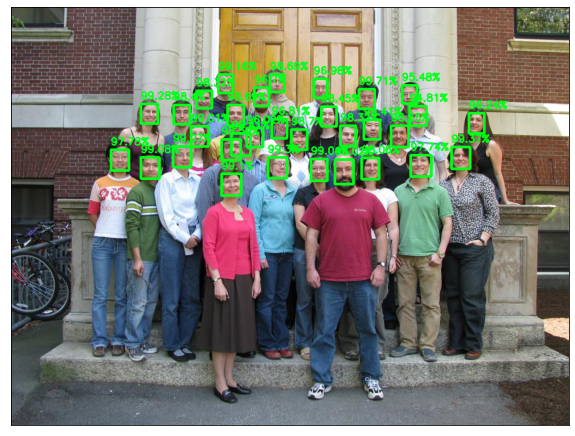

[<yolo.utils.bbox.BoundBox object at 0x7f9923186fd0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95cef98>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95ceef0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95cee48>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95cedd8>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95cecf8>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95cecc0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95cec50>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95cec18>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95ceb70>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95ceb00>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95cea58>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95cea20>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95ce9e8>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95ce9b0>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95ce908>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95ce898>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95ce828>, <yolo.utils.bbox.BoundBox object at 0x7f9ce95

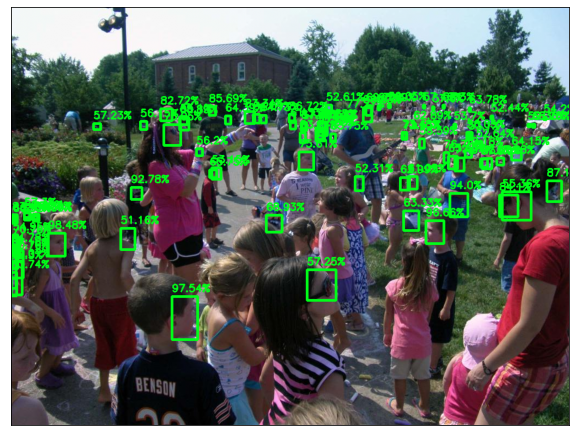

In [21]:
# Cargamos el modelo
if not model_loaded:
    yolov3 = load_model(config['valid']['valid_model'])
    print("Cargado modelo " + config['valid']['valid_model'])
    model_loaded = True

# Definimos un par de imágenes de prueba
annot1 = config['valid']['valid_annot_folder'] \
    + "12_Group_Group_12_Group_Group_12_227.xml"
annot2 = config['valid']['valid_annot_folder'] \
    + "18_Concerts_Concerts_18_38.xml"

# Detectamos caras en las imágenes de prueba
_ = detectar_imagen(
    yolov3,
    config['valid']['valid_image_folder'],
    annot1,
    mostrar_ground_truth = False)
_ = detectar_imagen(
    yolov3,
    config['valid']['valid_image_folder'],
    annot2,
    mostrar_ground_truth = False)

In [ ]:
# Cargamos el modelo
if not model_loaded:
    yolov3 = load_model(config['valid']['valid_model'])
    print("Cargado modelo " + config['valid']['valid_model'])
    model_loaded = True

# Detectamos caras en un vídeo
detectar_video(yolov3, DIR + "test.mp4", DIR + "test_out.mp4")